# Introduction to Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import sklearn.manifold, sklearn.cluster
import rdkit, rdkit.Chem, rdkit.Chem.Draw
# import dmol

### load data

In [2]:
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
# soldata = pd.read_csv(
#     "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
# )

soldata = pd.read_csv("/nfs/data/solubility_project/solubility_project_main/data/raw/aqsoldb/AqSolDB_curated-solubility-dataset.csv")
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


### data exploration

In [ ]:
# plot one molecule
mol = rdkit.Chem.MolFromInchi(soldata.InChI[0])
mol

In [ ]:
sns.histplot(soldata.Solubility)
plt.show()

In [ ]:
# get 3 lowest and 3 highest solubilities
soldata_sorted = soldata.sort_values("Solubility")
extremes = pd.concat([soldata_sorted[:3], soldata_sorted[-3:]])

# We need to have a list of strings for legends
legend_text = [
    f"{x.ID}: solubility = {x.Solubility:.2f}" for x in extremes.itertuples()
]

# now plot them on a grid
extreme_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in extremes.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    extreme_mols, molsPerRow=3, subImgSize=(250, 250), legends=legend_text
)

### feature correlation

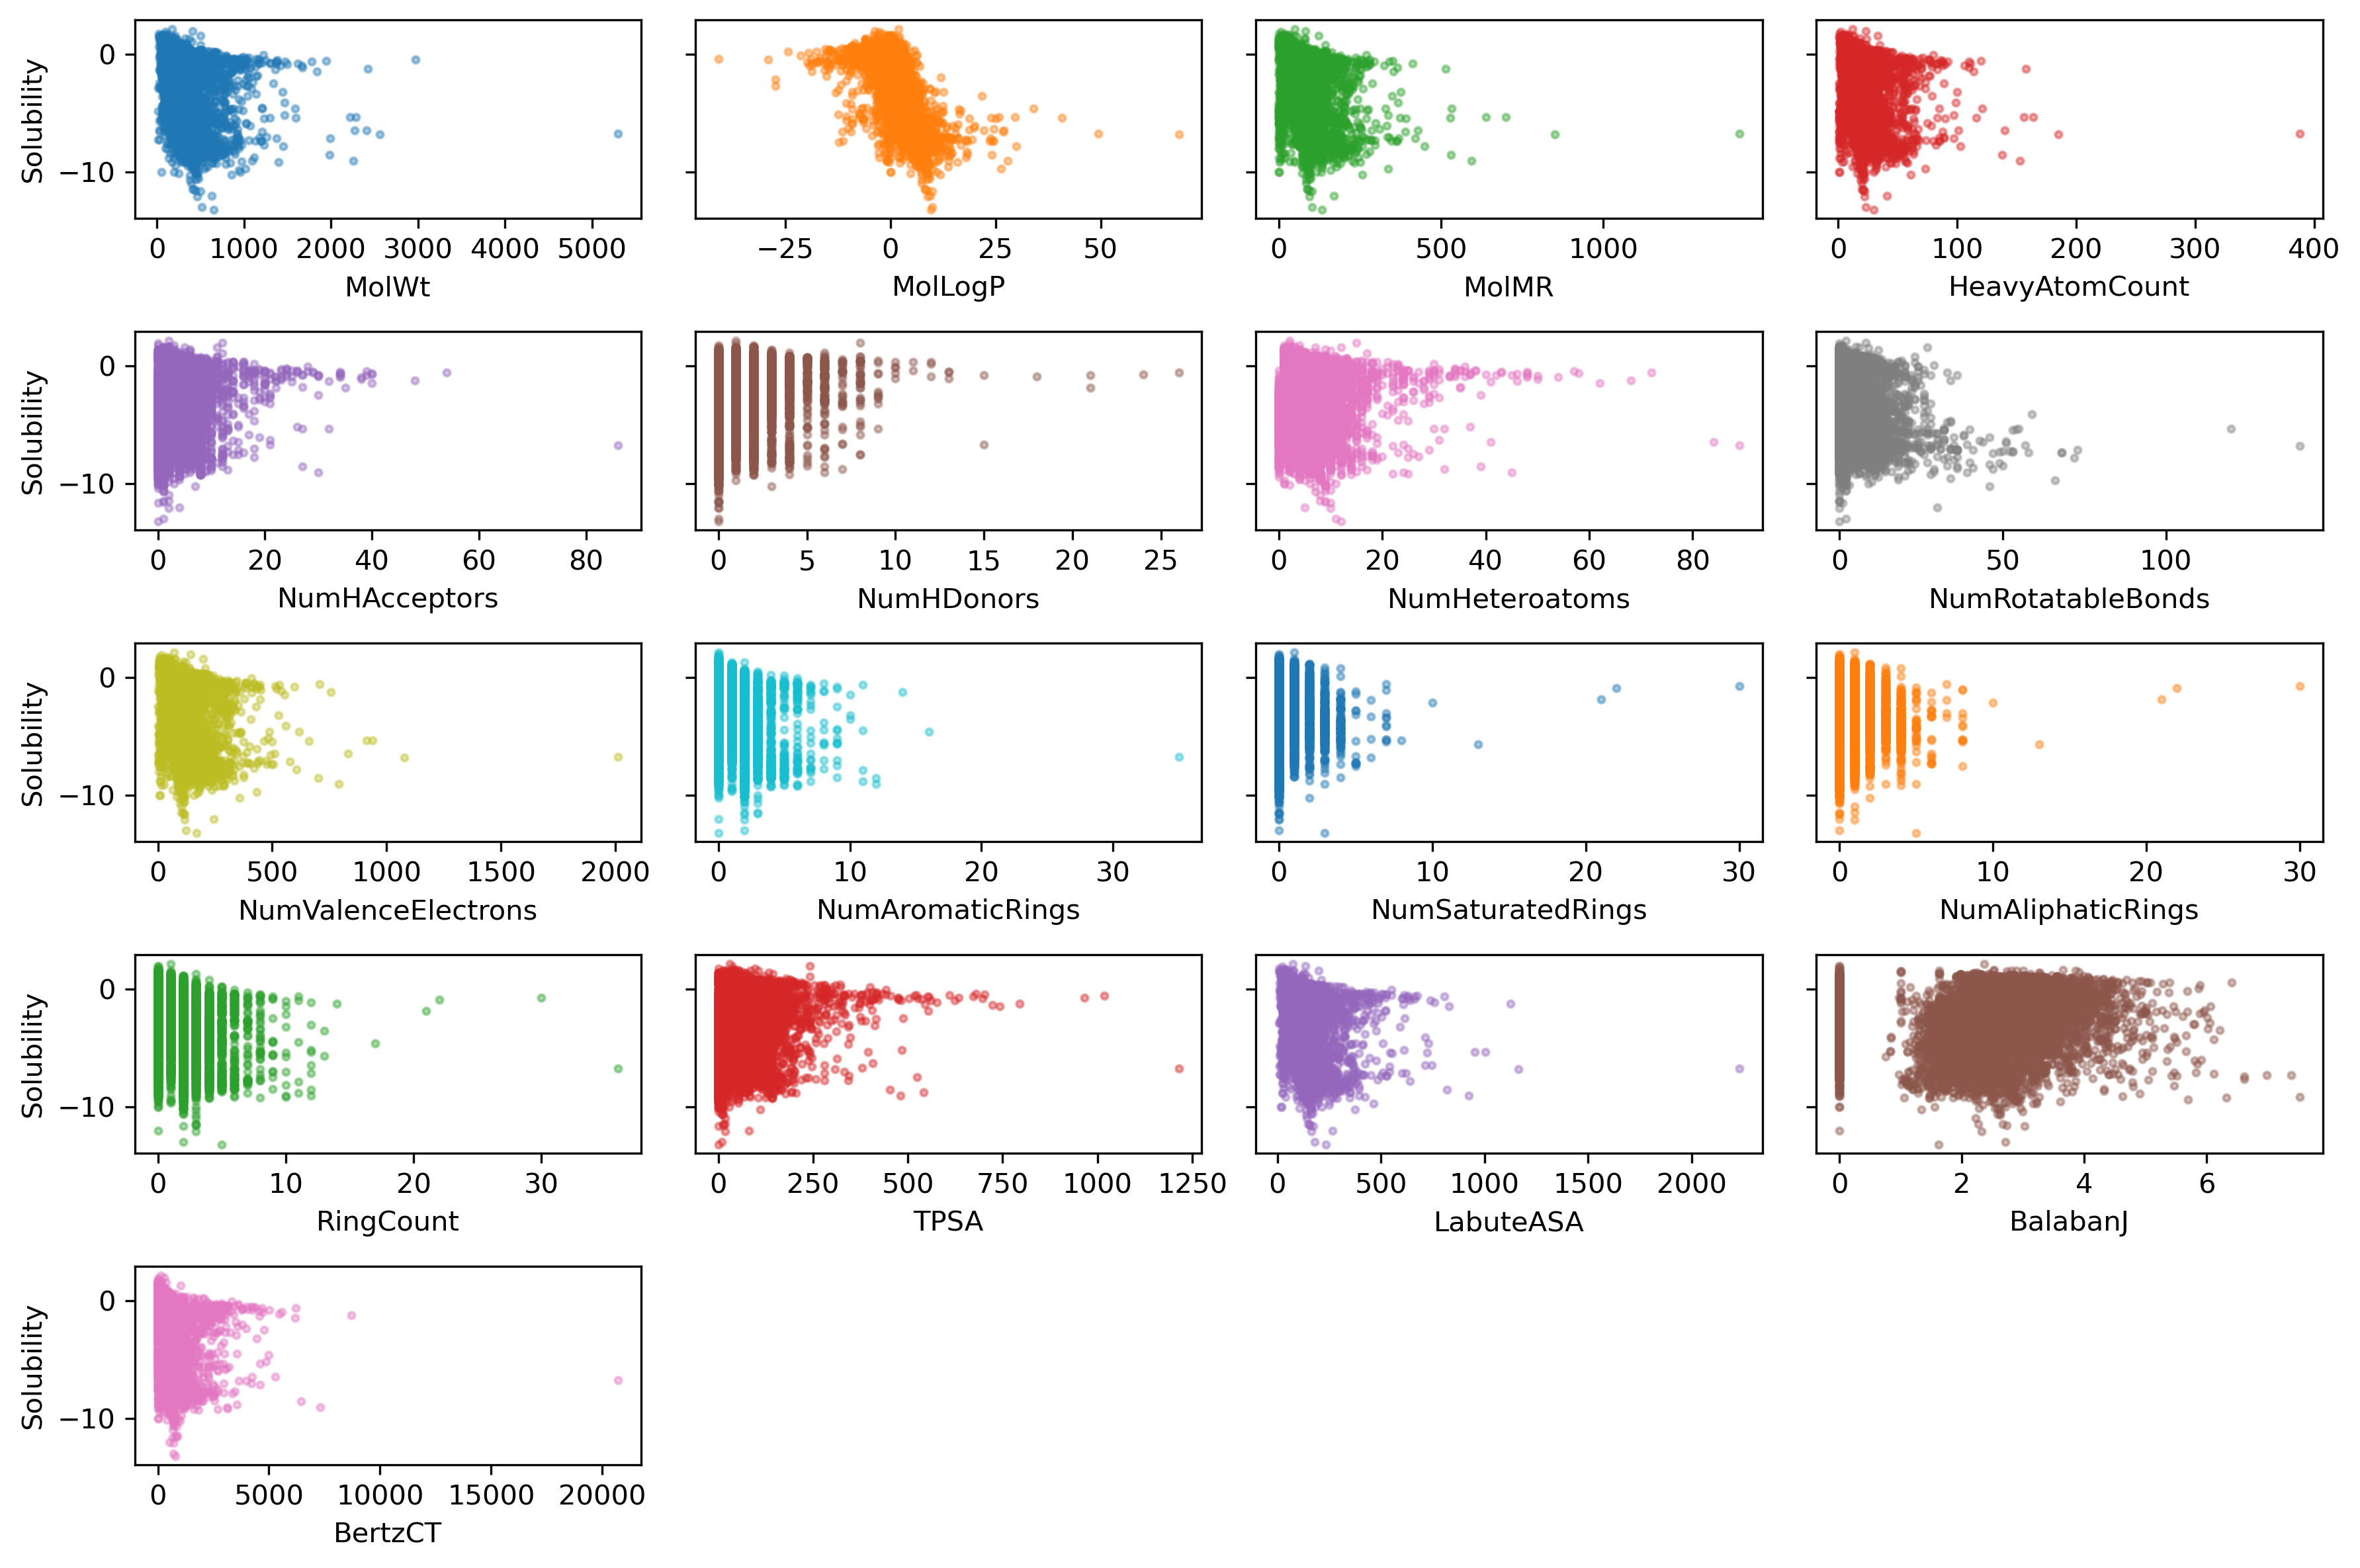

In [3]:
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        soldata[n], soldata.Solubility, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

### linear model

In [23]:
def linear_model(x, w, b):
    return jnp.dot(x, w) + b


# test it out
x = np.array([1, 0, 2.5])
w = np.array([0.2, -0.5, 0.4])
b = 4.3

linear_model(x, w, b)

Array(5.5, dtype=float32)

### gradient descent

In [24]:
# convert data into features, labels
features = soldata.loc[:, feature_names].values
labels = soldata.Solubility.values

feature_dim = features.shape[1]

# initialize our paramaters
w = np.random.normal(size=feature_dim)
b = 0.0


# define loss
def loss(y, labels):
    return jnp.mean((y - labels) ** 2) # rmse


# test it out
y = linear_model(features, w, b)
loss(y, labels)

Array(64543.12, dtype=float32)

In [25]:
# compute gradients
def loss_wrapper(w, b, data):
    features = data[0]
    labels = data[1]
    y = linear_model(features, w, b)
    return loss(y, labels)


loss_grad = jax.grad(loss_wrapper, (0, 1))

# test it out
loss_grad(w, b, (features, labels))

(Array([-7.0630454e+03, -3.0511372e+01, -3.2974504e+03, -1.0839979e+03,
        -2.8340460e+02,  6.4855186e+01, -2.5639264e+02,  7.3073694e+02,
        -2.6506318e+03, -4.3371802e+02,  4.6687561e+01, -5.6735444e+00,
        -4.3939114e+02, -1.8120646e+03, -5.1904980e+03,  3.8426450e+02,
        -1.6416958e+05], dtype=float32),
 Array(115.5571, dtype=float32, weak_type=True))

### training curve

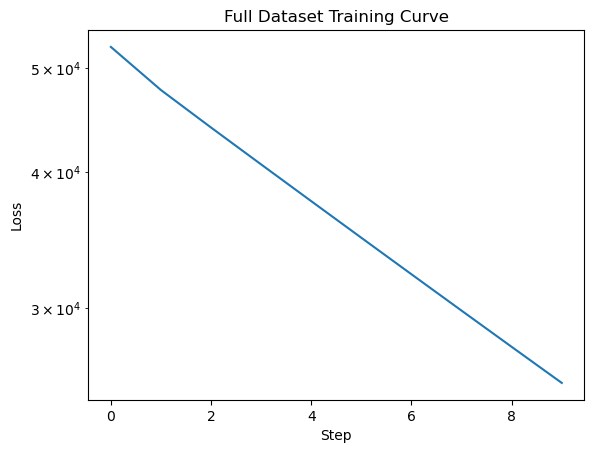

In [26]:
loss_progress = []
eta = 1e-6
data = (features, labels)
for i in range(10):
    grad = loss_grad(w, b, data)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss_wrapper(w, b, data))
plt.plot(loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Full Dataset Training Curve")
plt.show()

###  batching

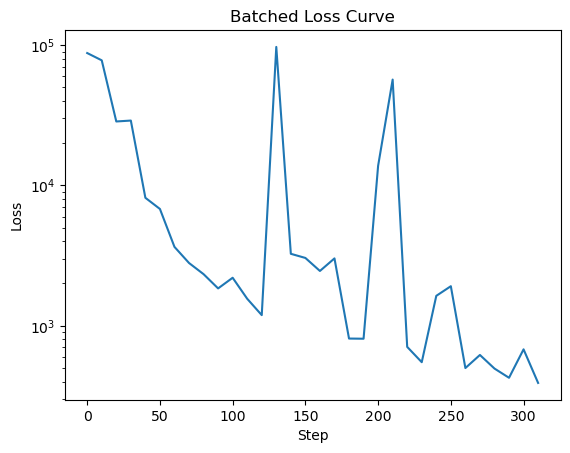

In [27]:
# initialize our paramaters
# to be fair to previous method
w = np.random.normal(size=feature_dim)
b = 0.0

loss_progress = []
eta = 1e-6
batch_size = 32
N = len(labels)  # number of data points
data = (features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(labels) // batch_size * batch_size

# the -1 means that numpy will compute
# what that dimension should be
batched_features = features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
# to make it random, we'll iterate over the batches randomly
indices = np.arange(new_N // batch_size)
np.random.shuffle(indices)
for i in indices:
    # choose a random set of
    # indices to slice our data
    grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
    w -= eta * grad[0]
    b -= eta * grad[1]
    # we still compute loss on whole dataset, but not every step
    if i % 10 == 0:
        loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 10, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Batched Loss Curve")
plt.show()

In [28]:
# standardize features 
fstd = np.std(features, axis=0)
fmean = np.mean(features, axis=0)
std_features = (features - fmean) / fstd

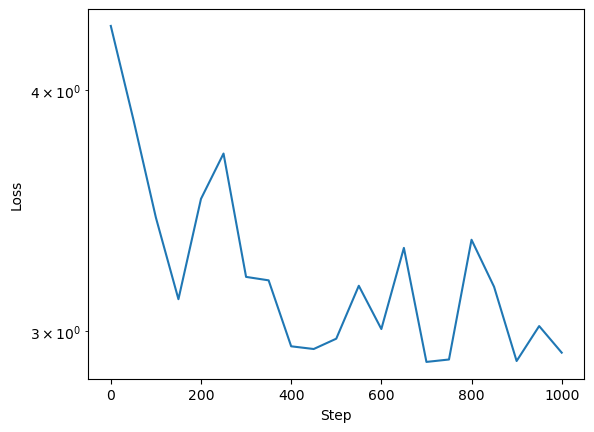

In [29]:
# initialize our paramaters
# since we're changing the features
w = np.random.normal(scale=0.1, size=feature_dim)
b = 0.0


loss_progress = []
eta = 1e-2
batch_size = 32
N = len(labels)  # number of data points
data = (std_features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(labels) // batch_size * batch_size
num_epochs = 3

# the -1 means that numpy will compute
# what that dimension should be
batched_features = std_features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
indices = np.arange(new_N // batch_size)

# iterate through the dataset 3 times
for epoch in range(num_epochs):
    # to make it random, we'll iterate over the batches randomly
    np.random.shuffle(indices)
    for i in indices:
        # choose a random set of
        # indices to slice our data
        grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
        w -= eta * grad[0]
        b -= eta * grad[1]
        # we still compute loss on whole dataset, but not every step
        if i % 50 == 0:
            loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 50, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.show()

In [ ]:
# analyzing model performance

predicted_labels = linear_model(std_features, w, b)

plt.plot([-100, 100], [-100, 100])
plt.scatter(labels, predicted_labels, s=4, alpha=0.7)
plt.xlabel("Measured Solubility $y$")
plt.ylabel("Predicted Solubility $\hat{y}$")
plt.xlim(-13.5, 2)
plt.ylim(-13.5, 2)
plt.show()

In [ ]:
# slice correlation between predict/labels
# from correlation matrix
np.corrcoef(labels, predicted_labels)[0, 1]
#>> A correlation coefficient of 0.65 is OK, but not great.

In [ ]:
# unsupervised learning

## Clustering
## Finding Signal (repersentation learning)
## Generative 

In [ ]:
# clustering

# get down to 2 dimensions for easy visuals
embedding = sklearn.manifold.Isomap(n_components=2)
# only fit to every 25th point to make it fast
embedding.fit(std_features[::25, :])
reduced_features = embedding.transform(std_features)

In [ ]:
xlow, xhi = np.quantile(reduced_features, [0.005, 0.995], axis=0)

plt.figure(dpi=300)
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=labels,
    edgecolors="none",
)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
cb = plt.colorbar()
cb.set_label("Solubility")
plt.show()

In [ ]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(std_features)

In [ ]:
plt.figure(dpi=300)
point_colors = [f"C{i}" for i in kmeans.labels_]
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=point_colors,
    edgecolors="none",
)
# make legend
legend_elements = [
    plt.matplotlib.patches.Patch(
        facecolor=f"C{i}", edgecolor="none", label=f"Class {i}"
    )
    for i in range(4)
]
plt.legend(handles=legend_elements)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
plt.show()

In [ ]:
# make an elbow plot
loss = []
cn = range(2, 15)
for i in cn:
    kmeans = sklearn.cluster.KMeans(n_clusters=i, random_state=0, n_init='auto')
    # use every 50th point
    kmeans.fit(std_features[::50])
    # we get score -> opposite of loss
    # so take -
    loss.append(-kmeans.score(std_features[::50]))

plt.plot(cn, loss, "o-")
plt.xlabel("Cluster Number")
plt.ylabel("Loss")
plt.title("Elbow Plot")
plt.show()

In [ ]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0, n_init = 'auto')
kmeans.fit(std_features)

cluster_center_idx = []
for c in kmeans.cluster_centers_:
    # find point closest
    i = np.argmin(np.sum((std_features - c) ** 2, axis=1))
    cluster_center_idx.append(i)
cluster_centers = soldata.iloc[cluster_center_idx, :]

legend_text = [f"Class {i}" for i in range(4)]

# now plot them on a grid
cluster_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in cluster_centers.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    cluster_mols, molsPerRow=2, subImgSize=(400, 400), legends=legend_text
)

# Exercises

## 2.6.1 data

Using numpy reductions np.amin, np.std, etc. (not pandas!), compute the mean, min, max, and standard deviation for each feature across all data points.

In [ ]:
import numpy as np

array1 = soldata.Solubility.values
print(array1.shape)
print(array1)
a_mean = np.mean(array1)
a_max = np.max(array1)
a_min = np.max(array1)
print("Mean: ", a_mean)
print("Min: ", a_min)
print("Max: ", a_max)
a_std = np.std(array1)
print("Standard deviation: ", a_std)

Use rdkit to draw the 2 highest molecular weight molecules. Note they look strange.

In [ ]:
soldata_sorted_wt = soldata.sort_values("MolWt")
highest_smis = soldata_sorted_wt['SMILES'].tolist()[-2:]
highest_mols = [rdkit.Chem.MolFromSmiles(x) for x in highest_smis]
# highest_smis = soldata_sorted_wt['InChI'].tolist()[-1:]
# highest_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in highest_smis]
legend_text = [f'Mw: {v}' for v in soldata_sorted_wt["MolWt"].tolist()[-2:]]

rdkit.Chem.Draw.MolsToGridImage(
    highest_mols, molsPerRow=2, subImgSize=(400, 400), legends=legend_text
)


## 2.6.2 linear models

prove that a nonlinear model like $y = \vec{w_1} * sin(\vec{x}) + \vec{w_2} * \vec{x} + b$ could be represented as a linear model.

re-write the equation: (the following is the respesentation as a linear model)

$y = \vec{w} * \vec{x} = [w_1, w_2, b] * [sin(x), x, 1]$



Write out the linear model equation in Einstein notation in batched form. Batched form means we explicitly have an index indicating batch. For example, the features will be where indicates the index in the batch and indicates the feature.

In [ ]:
### 



## 2.6.3 Minimizing loss

We standardized the features, but not the labels. Would standardizing the labels affect our choice of learning rate? Prove your answer.

In [30]:
# standardize label
lstd = np.std(labels, axis=0)
lmean = np.mean(labels, axis=0)
std_labels = (labels - lmean) / lstd


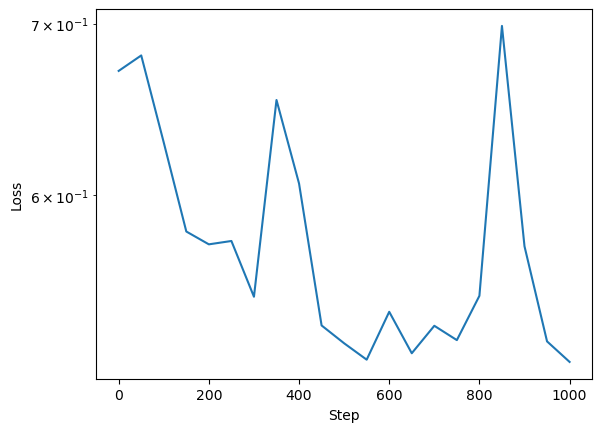

In [31]:
# initialize our paramaters
# since we're changing the features
w = np.random.normal(scale=0.1, size=feature_dim)
b = 0.0


loss_progress = []
eta = 1e-2
batch_size = 32
N = len(labels)  # number of data points
data = (std_features, std_labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(std_labels) // batch_size * batch_size
num_epochs = 3

# the -1 means that numpy will compute
# what that dimension should be
batched_features = std_features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = std_labels[:new_N].reshape((-1, batch_size))
indices = np.arange(new_N // batch_size)

# iterate through the dataset 3 times
for epoch in range(num_epochs):
    # to make it random, we'll iterate over the batches randomly
    np.random.shuffle(indices)
    for i in indices:
        # choose a random set of
        # indices to slice our data
        grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
        w -= eta * grad[0]
        b -= eta * grad[1]
        # we still compute loss on whole dataset, but not every step
        if i % 50 == 0:
            loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 50, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.show()

Implement a loss that is mean absolute error, instead of mean squared error. Compute its gradient using jax.

In [32]:
### 
# define loss
def loss_mae(y, labels):
    return jnp.mean((y - labels) ** 2) # mae

# compute gradients
def loss_wrapper_mae(w, b, data):
    features = data[0]
    labels = data[1]
    y = linear_model(features, w, b)
    return loss_mae(y, labels)


loss_grad_mae = jax.grad(loss_wrapper_mae, (0, 1))

# test it out
loss_grad_mae(w, b, (features, labels))


(Array([1.0145417e+05, 5.9262982e+02, 2.5780512e+04, 6.9615371e+03,
        1.5378546e+03, 3.6615042e+02, 2.1350869e+03, 1.2774791e+03,
        3.5858242e+04, 6.0686121e+02, 7.8449661e+01, 1.6330807e+02,
        7.7017242e+02, 2.5602766e+04, 4.2905527e+04, 3.6324518e+02,
        2.7990166e+05], dtype=float32),
 Array(200.73627, dtype=float32, weak_type=True))

Using the standardized features, show what effect batch size has on training. Use batch sizes of 1, 8, 32, 256, 1024. Make sure you re-initialize your weights in between each run. Plot the log-loss for each batch size on the same plot. Describe your results.

In [36]:
### 
def batch_test(batch_size):
    # initialize our paramaters
    # to be fair to previous method
    w = np.random.normal(size=feature_dim)
    b = 0.0

    loss_progress = []
    eta = 1e-6
    # batch_size = 32
    N = len(labels)  # number of data points
    data = (features, labels)
    # compute how much data fits nicely into a batch
    # and drop extra data
    new_N = len(labels) // batch_size * batch_size

    # the -1 means that numpy will compute
    # what that dimension should be
    batched_features = features[:new_N].reshape((-1, batch_size, feature_dim))
    batched_labels = labels[:new_N].reshape((-1, batch_size))
    # to make it random, we'll iterate over the batches randomly
    indices = np.arange(new_N // batch_size)
    np.random.shuffle(indices)
    for i in indices:
        # choose a random set of
        # indices to slice our data
        grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
        w -= eta * grad[0]
        b -= eta * grad[1]
        # we still compute loss on whole dataset, but not every step
        if i % 10 == 0:
            loss_progress.append(loss_wrapper(w, b, data))
    return loss_progress

loss_test = []
for batch_size in [1, 8, 32, 256, 1024]:
    print(batch_size)
    loss_test.append(batch_test(batch_size))


1
8
32
256
1024


In [37]:
print(loss_test[0])
print(loss_test[1])
print(loss_test[2])
print(loss_test[3])
print(loss_test[4])

[Array(2697347.2, dtype=float32), Array(11925.736, dtype=float32), Array(10830.931, dtype=float32), Array(8821.962, dtype=float32), Array(443001.34, dtype=float32), Array(66751.04, dtype=float32), Array(39254.152, dtype=float32), Array(25291.977, dtype=float32), Array(258336.22, dtype=float32), Array(7969.0933, dtype=float32), Array(6435.138, dtype=float32), Array(5848.3374, dtype=float32), Array(5220.646, dtype=float32), Array(5275.5576, dtype=float32), Array(5323.0044, dtype=float32), Array(4919.754, dtype=float32), Array(8673.651, dtype=float32), Array(5994.4204, dtype=float32), Array(8085.802, dtype=float32), Array(5168.04, dtype=float32), Array(4033.4631, dtype=float32), Array(15897.004, dtype=float32), Array(13221.403, dtype=float32), Array(6826.381, dtype=float32), Array(11866.198, dtype=float32), Array(31836.027, dtype=float32), Array(30132.287, dtype=float32), Array(53854.48, dtype=float32), Array(9174.992, dtype=float32), Array(5669.0293, dtype=float32), Array(4428.8955, dtyp

## 2.6.4 clustering

We say that clustering is a type of unsupervised learning and that it predicts the labels. What exactly are the predicted labels in clustering? Write down what the predicted labels might look like for a few data points.

In [ ]:
###
###  what the predicted lables would be?

In clustering, we predict labels from features. You can still cluster if you have labels, by just pretending they are features. Give two reasons why it would not be a good idea to do clustering in this manner, where we treat the labels as features and try to predict new labels that represent class.

On the isomap plot (reduced dimension plot), color the points by which group they fall in (G1, G2, etc.). Is there any relationship between this and the clustering?